# Univariate HP with Exponential Decay

In this notebook, we present an example use case of fitting (calibrating) and sampling from a univariate Hawkes (self-exciting) process with exponential delay density. Concretely, the HP is determined by the conditional intensity function

$$
\begin{align}
\lambda^*(t) &= \mu + \alpha \sum_{t_j < t} g_\theta(t - t_j) \\
g_\theta(x) &= -\theta \exp (-\theta x )
\end{align}
$$

In [1]:
import sys

sys.path.append("/home/caner/code/hawkes_bound/")

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from fasthawkes.model.uv_exp import UnivariateExpHawkesProcess as UVHP

## Example 1: FX Price Jump Data

Fit to real data and get Monte Carlo estimates of the distribution of number of occurrences via Ogata's modified thinning method.

In [3]:
df = pd.read_csv("example_data.csv", header=None)
df.columns = ["mark", "time"]

In [4]:
# take all mark 21 and fit a univariate exp HP
td = np.array(df.loc[df.mark == 21, :].get("time")).astype(np.float64)

proc = UVHP()
proc.fit(td, method="em")

-58566.648221072

In [5]:
# verify that the unconditional mean makes sense
mu, alpha, theta = proc.get_params()

N_approx = mu * td[-1] / (1 - alpha)

print(N_approx)
print(len(td))

8005.413329839444
8003


In [6]:
%%time
# take unconditioned samples from this HP, and estimate the distribution of 
# number of occurrences in a ten second period

counts = []
for j in range(100000):
    n = len(proc.sample(T=10000))  # time in millis
    counts.append(n)

CPU times: user 9.64 s, sys: 97.4 ms, total: 9.74 s
Wall time: 2.54 s


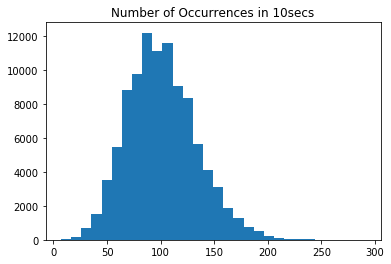

In [7]:
plt.title("Number of Occurrences in 10secs")
plt.hist(counts, bins=30)
plt.show()

## Example 2: Simulated Data

We simulate HPs and try to fit their parameters.

In [3]:
param_pairs = []
for j in range(100):
    # priors
    pars = np.random.gamma(3.), np.random.rand() * .3, np.random.gamma(5.)
#     print j
    hp = UVHP()
    hp.set_params(*pars)
    smp = hp.sample(100000,method="branching")
    
    # fit with gd
    hp2 = UVHP()
    hp2.fit(smp, method="gd")
    
    # fit with em
    hp3 = UVHP()
    hp3.fit(smp, method="em", reltol=1e-8)
    
    comb_pars = hp.get_params() + hp2.get_params() + hp3.get_params()
    param_pairs.append(comb_pars)
#     print param_pairs
    print ["%0.4f" % i for i in comb_pars]

['1.8645', '0.1990', '2.0969', '1.8594', '0.2004', '2.0542', '1.8585', '0.2008', '2.0470']
['3.2940', '0.1704', '2.7362', '3.2865', '0.1714', '2.6716', '3.2802', '0.1730', '2.6277']
['5.6339', '0.1035', '8.4447', '5.6147', '0.1071', '8.3124', '5.5163', '0.1228', '6.4613']
['2.5448', '0.1503', '6.5508', '2.5429', '0.1489', '6.6262', '2.5424', '0.1490', '6.6125']
['4.0137', '0.0097', '3.6862', '4.0520', '0.0000', '0.0037', '3.7862', '0.0656', '0.2048']
['2.1171', '0.2525', '3.4662', '2.1244', '0.2452', '3.6170', '2.1240', '0.2453', '3.6131']
['2.4068', '0.1990', '8.8620', '2.4102', '0.1995', '8.9486', '2.4099', '0.1996', '8.9391']
['5.5312', '0.2255', '6.6822', '5.4924', '0.2292', '6.6120', '5.4860', '0.2301', '6.5649']
['1.8536', '0.1756', '2.9556', '1.8537', '0.1790', '3.0153', '1.8530', '0.1793', '3.0060']
['3.3215', '0.2133', '3.5869', '3.3333', '0.2127', '3.6489', '3.3304', '0.2134', '3.6284']
['2.5943', '0.0792', '3.2470', '2.5862', '0.0832', '3.3586', '2.5654', '0.0905', '2.8866']

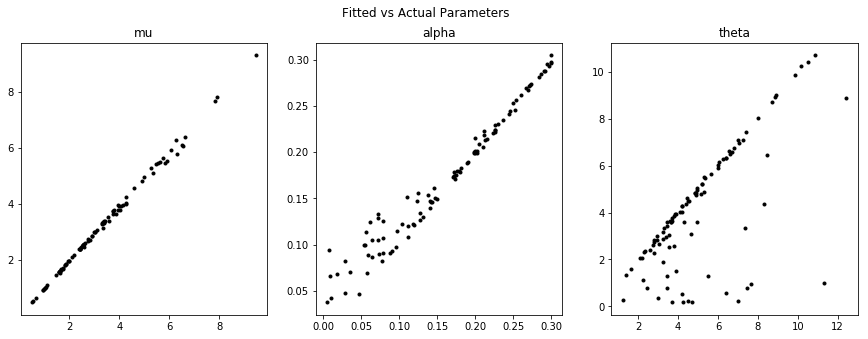

In [6]:
Z = np.array(param_pairs)

f, ax = plt.subplots(1, 3, figsize=(15,5))
f.suptitle("Fitted vs Actual Parameters")
for k in range(3):
    ax[k].plot(Z[:, k], Z[:, k+6], "k.")
    ax[k].set_title(["mu", "alpha", "theta"][k])

# ax[2].loglog()


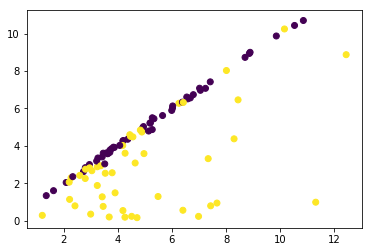

In [10]:
plt.scatter(Z[:, 2], Z[:, 8], c=Z[:,1] < .15)